<h1 align="center">Lab 2:  Sexism Identification in Twitter</h1>
<h2 align="center">Session 4. Transformers and Explainability</h2>
<h3 style="display:block; margin-top:5px;" align="center">Natural Language and Information Retrieval</h3>
<h3 style="display:block; margin-top:5px;" align="center">Degree in Data Science</h3>
<h3 style="display:block; margin-top:5px;" align="center">2024-2025</h3>    
<h3 style="display:block; margin-top:5px;" align="center">ETSInf. Universitat Politècnica de València</h3>
<br>

### Put your names here

- Marc Siquier
- Marcos Ranchal

### CONSTANTS

In [1]:
COLAB = False # IF YOU USE GOOGLE COLAB -> COLAB = True
PIP = False # IF YOU NEED INSTALL LIBRARIES -> PIP = True

**If you have trouble installing ferret-xai or jsonnet on Linux, try installing these packages first:**

- sudo apt install cmake   
- sudo apt install g++     
- sudo apt install make

**Or that after installing ferret-xai:**

- conda install -c conda-forge libstdcxx-ng --update-deps


## Some libraries

In [2]:
if PIP:
    !pip install transformers --upgrade
    !pip  install datasets accelerate --upgrade
    !pip install ferret-xai --upgrade
    !pip install tqdm

In [3]:
import os
import sys
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from typing import List, Tuple
import tqdm

## Import readerEXIST2025 library, and read the dataset

In [4]:
if COLAB is True:
  from google.colab import drive
  drive.mount('/content/drive')
  base_path = "/content/drive/MyDrive/LNR/"
else:
  base_path = "../"

In [5]:
library_path = os.path.join(base_path, "Lab2-S1")
sys.path.append(library_path)
from readerEXIST2025 import EXISTReader

In [6]:
# path to the dataset, adapt this path wherever you have the dataset
dataset_path = os.path.join(base_path, "../corpora/EXIST_2025_Dataset_V0.2/")

file_train = os.path.join(dataset_path, "EXIST2025_training.json")
file_dev = os.path.join(dataset_path, "EXIST2025_dev.json")

reader_train = EXISTReader(file_train)
reader_dev = EXISTReader(file_dev)

EnTrainTask1, EnDevTask1 = reader_train.get(lang="EN", subtask="1"), reader_dev.get(lang="EN", subtask="1")
SpTrainTask1, SpDevTask1 = reader_train.get(lang="ES", subtask="1"), reader_dev.get(lang="ES", subtask="1")

## Dataset class

In [7]:
class SexismDataset(Dataset):
    def __init__(self, texts, labels, ids, tokenizer, max_len=128, pad="max_length", trunc=True,rt='pt'):
        self.texts = texts.tolist()
        self.labels = labels
        self.ids = ids
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.pad = pad
        self.trunc = trunc
        self.rt = rt

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,padding=self.pad, truncation=self.trunc,
            return_tensors=self.rt
        )

        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long),
            'id': torch.tensor(self.ids[idx], dtype=torch.long)
        }

## Auxiliary functions

In [8]:
from collections import Counter # Counter counts the number of occurrences of each item
from itertools import tee, count

def uniquify(seq, suffs = count(1)):
    """Make all the items unique by adding a suffix (1, 2, etc).

    `seq` is mutable sequence of strings.
    `suffs` is an optional alternative suffix iterable.
    """
    not_unique = [k for k,v in Counter(seq).items() if v > 1] # so we have: ['name', 'zip']
    # suffix generator dict - e.g., {'name': <my_gen>, 'zip': <my_gen>}
    suff_gens = dict(zip(not_unique, tee(suffs, len(not_unique))))
    for idx,s in enumerate(seq):
        try:
            suffix = str(next(suff_gens[s]))
        except KeyError:
            # s was unique
            continue
        else:
            seq[idx] += suffix

def deduplicate(explanations):
    for i in range(len(explanations)):
        tokens = explanations[i].tokens
        uniquify(tokens, (f'_{x!s}' for x in range(1, 100)))
        explanations[i].tokens=tokens
    return explanations

# Two options to predict

### The simplest

In [ ]:
def predict_op1(model, dataset, args = {}):

    # Set up the Trainer, yes, a trainer for prediction!
    training_args = TrainingArguments(
        output_dir="./output",
        per_device_eval_batch_size = args.get("per_device_eval_batch_size", 16),
        do_train=False,
        do_eval=False,
    )
    trainer = Trainer(model=model, args=training_args)

    # Predict
    predictions = trainer.predict(val_dataset)

    # Get logits, shape = #samples, num_classes (2)
    logits = predictions.predictions
    
    # Compute probability with softmax, requires logits to be tensors (unnecessary to compute the class)
    probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1).numpy()    

    # Get the predicted class using argmax
    pred_classes = np.argmax(logits, axis=-1)
    # equals to: pred_classes = np.argmax(probs, axis=-1)

    # Get the probability of the predicted class
    pred_probs = probs[np.arange(len(pred_classes)), pred_classes]

    return pred_classes, pred_probs


### The coolest, if you know what you're doing

In [10]:
#EnTrainTask1, EnDevTask1 = reader_train.get(lang="EN", subtask="1"), reader_dev.get(lang="EN", subtask="1")
#SpTrainTask1, SpDevTask1

device = "cpu"
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")

def predict_op2(model, dataset, args = {}):
    # batch_size
    batch_size = args.get("per_device_eval_batch_size", 16)
    
    model.to(device)
    # Set eval model, no gradient stored
    model.eval()
    
    # Prepare DataLoader
    dataloader = DataLoader(dataset, batch_size=batch_size)
    
    # Prediction loop
    logits_list = []
    with torch.no_grad():
        for batch in tqdm.notebook.tqdm(dataloader):
            del batch["id"]
            batch = {k: v.to(device) for k, v in batch.items()}
            # equals to: outputs = model.forward(**batch)
            outputs = model(**batch)
            logits_list.append(outputs.logits)

    # Concatenate and move logits to the CPU, shape = #samples, num_classes (2)
    logits = torch.cat(logits_list, dim=0).cpu()

    # Compute probability with softmax, requires logits to be tensors (unnecessary to compute the class)
    probs = torch.nn.functional.softmax(logits, dim=-1).numpy()
    
    # Get the predicted class using argmax
    pred_classes = np.argmax(logits, axis=-1).numpy()
    # equals to: pred_classes = np.argmax(probs, axis=-1).numpy()

    
    # COMPLETE TO ALSO RETURN THE PROBABILITY OF THE PREDICTED CLASS
    
    return pred_classes


### Predictions from the best Spanish model

In [11]:
# COMPLETE
model_name = "" # path to your best Spanish model
base_model = "" # the name model your best model is based on. It is necessary if your model doesn't include a tokenizer


tokenizer = AutoTokenizer.from_pretrained(base_model)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

val_dataset = SexismDataset(SpDevTask1[1], LabelEncoder().fit_transform(SpDevTask1[2]), [int(x) for x in SpDevTask1[0]], tokenizer)

preds, probs = predict_op1(model, val_dataset)

# If you want to verify that both options do the same, try this:
#y_pred1, _ = predict_op1(model, val_dataset)
#y_pred2, _ = predict_op2(model, val_dataset)
#all(x1 == x2 for x1, x2 in zip(y_pred1, y_pred2))

### Evaluation of the results

In [12]:
def compute_metrics(y_true, y_pred):
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='binary'
    )
    acc = accuracy_score(y_true, y_pred)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
    }

# Metrics
metrics = compute_metrics(val_dataset.labels, preds)
print("Metrics:", metrics)

# Confusion matrix
conf_matrix = confusion_matrix(val_dataset.labels, preds)#, labels=["NO", "YES"])
print("\nConfusion matrix:")
print(conf_matrix)

# Classification report
class_report = classification_report(val_dataset.labels, preds, target_names=["NO", "YES"], digits=4)
print("\nReport:")
print(class_report)

Metrics: {'accuracy': 0.8673469387755102, 'f1': 0.8717948717948718, 'precision': 0.8983739837398373, 'recall': 0.8467432950191571}

Confusion matrix:
[[204  25]
 [ 40 221]]

Report:
              precision    recall  f1-score   support

          NO     0.8361    0.8908    0.8626       229
         YES     0.8984    0.8467    0.8718       261

    accuracy                         0.8673       490
   macro avg     0.8672    0.8688    0.8672       490
weighted avg     0.8693    0.8673    0.8675       490



### Plot confusion matrix


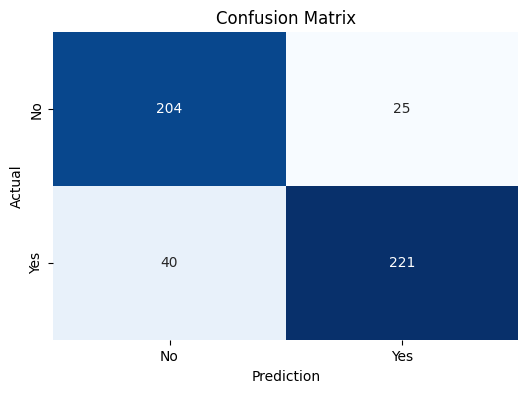

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No", "Yes"],
            yticklabels=["No", "Yes"])
plt.title("Confusion Matrix")
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.show()

### Text and probability of False positive and False negative

In [14]:
def false_positive_false_negative(
    y_true: List[int], y_pred: List[int], pred_probs: List[float], texts: List[str]
) -> Tuple[List[Tuple[float, str]], List[Tuple[float, str]]]:
    """
    returns incorrect predictions from a binary classification model.

    Parameters:
    - y_true (list[int]): True labels for each sample (0 or 1).
    - y_pred (list[int]): Labels predicted by the model (0 or 1).
    - pred_probs (list[float]): Probabilities assigned by the model to the predicted class.
    - texts (list[str]): Text of each sample.

    Returns:
    - false_positives (list[tuple[float, str]]): List of tuples for false positives.
    - false_negatives (list[tuple[float, str]]): List of tuples for false negatives.
    Each tuple of both lists includes the probability and the text of the sample.
    """

    false_positive = []
    false_negative = []
    
    # COMPLETE!!!
    
    return false_positive, false_negative

In [15]:
fpositive, fnegative = false_positive_false_negative(y_true = val_dataset.labels, y_pred = preds, pred_probs = probs, texts = val_dataset.texts)

print("False positive:", len(fpositive))
for s in fpositive:
    print('**', s)

print("\n\nFalse negative:", len(fnegative))
for s in fnegative:
    print('**', s)

False positive: 25
** (0.97861713, 'Adoro las fotos pero están usando mal el término, el manspreading no es solo sentarse con las piernas abiertas. :/ https://t.co/EMrpmRrSdD')
** (0.9749672, '@PSOE @Adrilastra La prostitución forzada, el proxenetismo, el rufianismo, la trata o como queráis llamarlo, ya está contemplado en el Código Penal como delito. Lo que no se debe ilegalizar, sea o no moralmente reprochable, es que una persona disponga de su cuerpo libremente.')
** (0.97452116, 'Nos roban a manos llenas. Sólo les falta violar a tus familiares y sodomizar s tus hijos.')
** (0.97444034, '@IreneMontero @IreneMontero, efectivamente.. las mujeres no deben de ser discriminadas salarialmente por pertenecer a cuerpos policiales de otras comunidades, localidades, etc.')
** (0.9739942, '@Cristina_Coach @Dillita1 @lapropriaWinter @Alex_con_3X ¿Usted acaso vio a Ruiz Cortines saliendo a militar con movimientos feministas? Promulgó una ley que amparó un derecho para las mujeres, no era ningún 

### Select some samples to analyze

You can select the samples with more confidence, those with less confidence, a mix of both, or simply the ones you consider more interesting. 



**Try not to choose the same samples that I’ve selected, and Justify your decision**.


In [16]:
# Make your own selection

# COMPLETE !
fpositive_samples = [

]

fnegative_samples = [

]

In [17]:
from ferret import Benchmark
from IPython.display import display_html

# selecting the benchmark
bench = Benchmark(model, tokenizer)#, explainers=[s,l])
# If you have trouble with this benchmark (runtime errors), try using just those two explainers.
    #from ferret.explainers.shap import SHAPExplainer
    #from ferret.explainers.lime import LIMEExplainer
    #lexp = LIMEExplainer(model, tokenizer)
    #sexp = SHAPExplainer(model, tokenizer)
    #bench = Benchmark(model, tokenizer, explainers=[sexp,lexp])

def explain_this(benchmark, sentence, target):
    explanations = benchmark.explain(sentence, target=target)
    explanations_de = deduplicate(explanations)
    explanation_evaluations = benchmark.evaluate_explanations(explanations_de, target=target)
    print("Sentence:", sentence)
    print("Class:", target)
    tble = benchmark.show_table(explanations_de)
    tble2 = benchmark.show_evaluation_table(explanation_evaluations)
    display_html(tble.to_html(), raw=True)
    display_html(tble2.to_html(), raw=True)

### Show explanations

In [18]:
for sample in fpositive_samples:
    print("False Positive:")
    explain_this(bench, sample, 1)
    print("\n\n")

for sample in fnegative_samples:
    print("False Negative:")
    explain_this(bench, sample, 0)
    print("\n\n")

False Positive:


Explainer:   0%|          | 0/6 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Explanation eval:   0%|          | 0/6 [00:00<?, ?it/s]

Sentence: chacha un mes ignorándome y ahora me vai a felicitar cómo si nada? 🖕🏼
Class: 1


Token,▁ch,acha,▁un,▁mes,▁ignor,andome,▁y,▁ahora,▁me,▁vai,▁a,▁felicitar,▁como,▁si,▁nada?,▁
Partition SHAP,0.13,0.09,-0.04,-0.02,0.16,0.19,0.04,-0.02,0.10,0.04,0.04,-0.03,0.01,0.03,0.02,0.03
LIME,0.13,0.11,-0.04,-0.00,0.23,-0.00,0.00,0.01,-0.01,0.14,0.04,-0.09,0.01,-0.04,0.05,-0.08
Gradient,0.13,0.27,0.03,0.04,0.08,0.05,0.01,0.02,0.02,0.11,0.01,0.11,0.01,0.01,0.04,0.01
Gradient (x Input),0.07,-0.17,0.00,-0.05,0.03,0.01,0.03,0.08,-0.12,-0.17,0.06,0.06,-0.00,-0.07,-0.04,0.01
Integrated Gradient,-0.16,0.01,0.06,0.10,-0.05,-0.02,-0.01,0.01,-0.01,0.13,-0.01,0.11,-0.01,0.05,0.13,0.08
Integrated Gradient (x Input),0.07,0.10,0.01,0.07,0.19,0.13,-0.02,-0.04,-0.01,0.12,-0.00,-0.01,-0.04,-0.04,0.12,-0.04


,aopc_compr,aopc_suff,taucorr_loo
Partition SHAP,0.46,0.11,0.28
LIME,0.36,0.04,0.23
Gradient,0.30,0.02,0.50
Gradient (x Input),0.24,0.47,0.08
Integrated Gradient,0.08,0.34,-0.17
Integrated Gradient (x Input),0.24,0.19,0.42





False Positive:


Explainer:   0%|          | 0/6 [00:00<?, ?it/s]

Explanation eval:   0%|          | 0/6 [00:00<?, ?it/s]

Sentence: Adoro las fotos pero están usando mal el término, el manspreading no es solo sentarse con las piernas abiertas. :/ https://t.co/EMrpmRrSdD
Class: 1


Token,▁adoro,▁las_1,▁fotos,▁pero,▁estan,▁usando,▁mal,▁el_1,▁termin,"o,",▁el_2,▁mans,pre,ad,ing,▁no,▁es,▁solo,▁sentarse,▁con,▁las_2,▁piernas,▁abier,tas.,▁:/,▁htt,ps,:,//,t.,co,/,em,r,pm,rr,s,dd
Partition SHAP,-0.00,0.01,-0.01,-0.00,-0.01,0.00,0.01,-0.01,-0.00,-0.00,0.00,0.43,0.03,0.23,-0.05,-0.00,-0.02,-0.02,-0.00,-0.02,0.02,0.06,0.00,-0.00,0.00,-0.01,-0.01,0.00,-0.00,-0.00,-0.01,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00
LIME,0.01,0.03,-0.02,0.00,0.02,-0.01,0.01,0.01,-0.02,0.02,-0.01,0.34,0.05,0.10,0.04,-0.02,0.00,-0.00,-0.01,-0.00,0.02,0.06,0.01,0.02,-0.04,0.00,0.00,-0.01,-0.01,0.00,0.01,0.01,0.01,0.01,0.03,-0.01,-0.00,0.00
Gradient,0.05,0.01,0.03,0.01,0.01,0.02,0.01,0.01,0.04,0.01,0.01,0.12,0.04,0.02,0.06,0.01,0.01,0.02,0.07,0.01,0.01,0.09,0.05,0.03,0.04,0.06,0.01,0.01,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
Gradient (x Input),-0.01,0.02,0.03,-0.00,0.02,0.05,-0.00,0.01,0.05,0.02,0.01,0.16,0.02,0.01,0.16,0.01,0.01,-0.00,-0.01,-0.01,-0.01,0.05,-0.05,0.05,0.05,-0.02,-0.01,0.01,0.02,0.02,0.01,0.00,-0.00,-0.02,0.01,0.01,-0.00,0.00
Integrated Gradient,-0.03,0.02,-0.04,0.00,-0.00,0.01,-0.01,0.02,-0.00,-0.04,0.01,-0.03,0.01,-0.02,-0.06,0.02,0.01,-0.02,-0.05,-0.02,-0.01,0.10,-0.07,-0.01,0.07,0.06,-0.01,0.01,-0.03,-0.01,-0.01,-0.02,0.01,0.00,-0.02,-0.03,-0.01,-0.07
Integrated Gradient (x Input),0.02,0.03,-0.02,0.01,0.02,0.00,0.02,-0.00,0.03,0.01,-0.02,0.24,-0.00,0.03,0.24,0.02,0.00,-0.00,0.02,0.03,0.01,0.04,0.01,0.01,-0.00,-0.01,0.00,-0.00,0.00,0.02,-0.00,-0.00,0.01,0.01,0.01,-0.00,-0.02,0.05


,aopc_compr,aopc_suff,taucorr_loo
Partition SHAP,0.93,0.13,-0.09
LIME,0.93,0.04,0.25
Gradient,0.80,0.07,-0.07
Gradient (x Input),0.88,0.29,0.16
Integrated Gradient,0.00,0.83,-0.13
Integrated Gradient (x Input),0.90,0.13,0.10





False Negative:


Explainer:   0%|          | 0/6 [00:00<?, ?it/s]

Explanation eval:   0%|          | 0/6 [00:00<?, ?it/s]

Sentence: Ando mas relajado que papá con hija fea por que no salgo en estos tik toks😮‍💨
Class: 0


Token,▁ando,▁mas,▁rela,jado,▁que_1,▁papa,▁con,▁hija,▁fea,▁por,▁que_2,▁no,▁salgo,▁en,▁estos,▁tik,▁to,ks
Partition SHAP,0.07,0.05,0.07,0.09,-0.06,0.02,0.14,-0.10,-0.22,-0.01,0.00,-0.03,-0.03,0.01,0.03,-0.02,-0.03,0.04
LIME,0.13,0.04,0.19,0.09,-0.04,0.05,0.06,-0.05,-0.06,-0.03,0.03,-0.06,-0.02,-0.00,0.02,-0.01,-0.08,0.01
Gradient,0.06,0.02,0.06,0.07,0.02,0.10,0.05,0.18,0.19,0.02,0.01,0.01,0.04,0.01,0.02,0.08,0.02,0.02
Gradient (x Input),-0.04,0.02,0.08,0.08,0.03,-0.02,0.02,-0.38,0.06,-0.02,-0.00,-0.01,0.05,-0.00,0.00,0.09,0.01,0.06
Integrated Gradient,-0.00,0.03,-0.02,0.06,-0.02,-0.02,-0.01,-0.29,-0.27,0.02,-0.01,-0.03,0.06,0.00,-0.02,-0.10,0.02,0.00
Integrated Gradient (x Input),-0.05,0.05,0.12,0.18,0.04,-0.18,-0.08,-0.06,-0.03,-0.00,0.02,0.03,-0.12,0.01,0.02,-0.01,0.00,-0.01


,aopc_compr,aopc_suff,taucorr_loo
Partition SHAP,0.57,-0.04,0.50
LIME,0.48,-0.01,0.37
Gradient,0.06,0.23,-0.03
Gradient (x Input),0.17,0.07,-0.02
Integrated Gradient,0.18,0.23,0.16
Integrated Gradient (x Input),0.30,-0.03,0.16





False Negative:


Explainer:   0%|          | 0/6 [00:00<?, ?it/s]

Explanation eval:   0%|          | 0/6 [00:00<?, ?it/s]

Sentence: Es literalmente romantización de relaciones abusivas pero ahora en live action🤪🤪🤩🤩
Class: 0


Token,▁es,▁literalmente,▁roman,tizacion,▁de,▁relaciones,▁abus,ivas,▁pero,▁ahora,▁en,▁live,▁action
Partition SHAP,0.07,-0.09,-0.07,-0.01,0.00,0.07,-0.25,-0.12,0.04,0.08,-0.02,0.14,0.03
LIME,0.08,-0.13,-0.10,-0.01,0.03,0.12,-0.28,-0.05,-0.00,0.03,-0.01,0.09,0.07
Gradient,0.01,0.06,0.11,0.10,0.01,0.20,0.16,0.08,0.01,0.02,0.01,0.07,0.12
Gradient (x Input),-0.00,-0.03,0.15,0.03,-0.00,-0.49,0.00,-0.16,0.02,-0.03,-0.00,0.06,0.02
Integrated Gradient,0.04,-0.00,0.09,-0.24,-0.06,0.04,-0.03,-0.14,-0.03,-0.00,-0.13,-0.08,-0.02
Integrated Gradient (x Input),0.12,-0.12,-0.12,-0.01,0.08,-0.06,-0.11,-0.14,-0.01,0.07,0.00,-0.01,-0.14


,aopc_compr,aopc_suff,taucorr_loo
Partition SHAP,0.53,-0.12,0.56
LIME,0.58,-0.08,0.62
Gradient,-0.01,0.21,-0.10
Gradient (x Input),0.19,0.02,-0.08
Integrated Gradient,0.20,-0.07,0.15
Integrated Gradient (x Input),0.09,0.00,0.23


# DO IT IN ENGLISH

In [19]:
# COMPLETE